Цель  - анализ финансовых показателей компаний среди разработчиков информационных технологий. 
- собираем информацию по компаниям с ресурса - https://www.testfirm.ru
- проводим анализ по этой информации

In [2]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import re
import time
from google.colab import files # импорт/экспорт файлов
import matplotlib.pyplot as plt


# Создание списка компаний

In [ ]:
url1 = 'https://www.testfirm.ru/' # сайт
url2 = 'https://www.testfirm.ru/rating/63_11_1/' # стр. с рейтингом выручки/ или начало адреса стр. с рейтингом выручки
url3 = 'https://www.testfirm.ru/rating-assets/63_11_1/' # стр. с рейтингом активов
url4 = 'https://www.testfirm.ru/result/' # начало адреса стр с инф. о  компании

## 1 вариант - Сбор информации со списка из первых 50 фирм - с первой страницы фильтра. Минус варианта в том, что в список попадет только 50 компаний. Хотя в рейтинге намного больше фирм. 

In [ ]:
url_list = 'https://www.testfirm.ru/rating' # рейтинг по всем предприятиям 
k_1 = 63   #код деятельности
k_2 = "sverdlovskaya-oblast"  #область
url_list_copm = url_list + '/' + str(k_1) + '/' + k_2 + '/'
text = requests.get(url_list_copm) # 
try:
  text.status_code == 200
  print('Список загружен нормально')
except:
  print('ОШИБКА! Проверяй!')

Список загружен нормально


In [ ]:
# поиск названия компании
text_write = text.text

def find_komp(text_write, N):
    """ф. для поиска ИНН и названия по каждой компании - для формирования url-ссылки на информацию по этой компании
    """
    firma_list = text_write.split('org-link" href="/result/')
    return firma_list[N].split('"')[0]

def find_komp_re(text_write, N):
  """  ф. для поиска ИНН и названия по каждой компании - с помощью регулярных выражений
  """
  pass    

## 2 вариант - Сбор информации со списка из всех фирм фильтра. Попытка собрать данные со всех компаний рейтинга - без ограничений

### - загрузим страницу с рейтингом компаний

In [ ]:
# Рейтинг организаций по выручке - Вид деятельности: 63 "Деятельность в области информационных технологий"
url_list_all = url1 + 'rating/63/' # адрес страницы с рейтингом
text_list_all = requests.get(url_list_all) # 
try:
  text_list_all.status_code == 200
  print('Список загружен нормально')
except:
  print('ОШИБКА! Проверяй!')

Список загружен нормально


### - функции необходимые для кода

In [ ]:
def find_name(url):
    """ ф. находит инфу для url страницы с информацией по компании - состоит из ИНН и названия Компании
    -  inn_firma 
    """
    text = requests.get(url)
    text_find = text.text 
    text_find = text_find.split('class="org-link"')[1].split('result/')[1].split('">')[0]
    return text_find

def find_name_next(url, koef = 1):
    """ ф. находит инфу для url страницы с информацией по следующей компании
    """
    text = requests.get(url)
    text_find = text.text 
    text_find = text_find.split('class="org-link"')[koef].split('result/')[1].split('">')[0]
    return text_find  

In [ ]:
#url_one = 'https://www.testfirm.ru/result/' + name #   https://www.testfirm.ru/result/7708119944_ooo-sibirskaya-internet-kompaniya
def find_info_comp(url_one):
    """ ф.собирает информацию по каждой компании и сохраняет данные в строку
    """
    stroka = [] # собираем информацию сюда
    text_one = requests.get(url_one)
    text_write = text_one.text
    a1 = text_write.split('Организация: ')[1]
    if text_write.split('id="searchText" name="s" value=')[1].split('placeholder')[0]: # название
        stroka.append(text_write.split('id="searchText" name="s" value=')[1].split('placeholder')[0])
    else:
        stroka.append(0)
    stroka.append(a1.split('ИНН: ')[1][:10]) # ИНН
    stroka.append(float(a1.split('<b>')[2].split('<')[0].rstrip())) # активы
    mln = a1.split('Активы на ')[1].split('/b>')[1][:5].rstrip() # млн или тыс
    if mln in 'млн.':
        stroka.append(1)
    elif mln in 'тыс.':
        stroka.append(0.001)
    stroka.append(float(a1.split('Выручка')[1].split('b>')[1].split('<')[0].rstrip())) # выручка
    mln = a1.split('Выручка')[1].split('b>')[2].split('руб')[0].rstrip() # млн ии тыс
    if mln in 'млн.':
        stroka.append(1)
    elif mln in 'тыс.':
        stroka.append(0.001)
    if 'численности ' in text_write:
        stroka.append(int(a1.split('численности ')[1].split('b>')[1].split('<')[0])) # численность человек
    else:
        stroka.append(0) 
    if 'Дополнительные данные ФНС' in text_write:
        stroka.append(float(a1.split('Дополнительные данные ФНС')[1].split('padding-left:12px"><b>')[1].split('<')[0].rstrip())) # доходы 
        stroka.append(float(a1.split('Дополнительные данные ФНС')[1].split('padding-left:12px"><b>')[2].split('<')[0].rstrip())) # расходы
    else:
        stroka.append(0)
        stroka.append(0)
    if "Уплачено налогов" in text_write:
        stroka.append(float(text_write.split("Уплачено налогов")[1].split('b>')[1].split('<')[0].rstrip())) # налоги уплаченные
    else:
        stroka.append(0)
    return stroka

# надо бы дописать эту функцию
def find_info_comp_re(List_all_komp, n_comp):
    """ ф.собирает информацию по каждой компании и сохраняет данные в строку с помощью регулярных выражений
    """
    pass

In [ ]:
def info_p(value):
  """ ф. чистит каждое значение - переводит его в int
  """
  pass

### - соберем данные. В этом варианте сбор заканчивается на 553 компании(планирую до 6500), дальше идет дублирование информации - 2 последних компании начинают дублироваться в списке

In [ ]:
t0 = time.time()
Table_find_values = [] 

name = find_name(url_list_all)      # ф. найдет определитель компании - inn_firma
url_one = url1 + 'result/' + name   # url страницы с информацией о компании
text_one = requests.get(url_one)    # создат объект Response
a = find_info_comp_primer(url_one)             # ф. покажет инф. о компании
#print(a)
Table_find_values.append(a)
inn = name.split('_')[0]            # выделить инн
url_1 = url1 + 'rating/63_11_1/' + inn + '/' # url страницы с местом в рейтинге  / вернутся в рейтинг фирм
print('\t \t 1')

name_next_1 = requests.get(url_1).text.split(name)[1].split('href="/result/')[1].split('">')[0] # найти name следующей компании
inn_next = name_next_1.split('_')[0]
url_next_company = url1 + 'result/' + name_next_1
a = find_info_comp_primer(url_next_company) #  ф. покажет инф. о компании
#print(a)
Table_find_values.append(a)
url_1 = url1 + 'rating/63_11_1/' + inn_next + '/' # url страницы с местом в рейтинге  / вернутся в рейтинг фирм
print('\t \t 2')

for i in range(550):
    name_next_1 = requests.get(url_1).text.split(name_next_1)[1].split('href="/result/')[1].split('">')[0] # найти name следующей компании
    inn_next = name_next_1.split('_')[0]
    url_next_company = url1 + 'result/' + name_next_1
    a = find_info_comp_primer(url_next_company) #  ф. покажет инф. о компании
 #   print(a)
    Table_find_values.append(a)
    url_1 = url1 + 'rating/63_11_1/' + inn_next + '/' # url страницы с местом в рейтинге  / вернутся в рейтинг фирм 
    print('\t \t', i + 3)

### - соберем данные. В этом варианте сбор информации опять заканчивается на 553 компании. А дальше идет дублирование информации с последней компании

In [ ]:
#
t0 = time.time()
Table_find_values = [] 
#
t2 = requests.get(url2).text                 # самая первая стр с рейтингом
#t2 = requests.get('https://www.testfirm.ru/rating/63_11_1/7736536731/').text    # https://www.testfirm.ru/rating/63_11_1/7736536731/
t2 = t2.split('org-link" href="/result/') # инф о самой первой стр с рейтингом
INN_name = t2[1].split('">')[0]                 # INN_name первой компании / t2[1]
INN_name_next_1 = t2[2].split('">')[0] ## INN_name второй компании /  t2[2]
INN_name_next_2 = t2[3].split('">')[0] ## INN_name третьей компании /  t2[2]
Table_find_values.append(find_info_comp_primer(url4 + INN_name))
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_1))
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_2))
#

for i in range(554):
    INN_next_1 = INN_name_next_1.split('_')[0] # инн следующей следующей компании
    url = url2 + INN_next_1 + '/'
    t2 = requests.get(url).text                 #  стр с рейтингом 
    t3 = t2.split(INN_name_next_1)[1].split('org-link" href="/result/') #стр с рейтингом после компании, разбивка по компаниям
    INN_name_next_1 = t3[1].split('">')[0]
    INN_name_next_2 = t3[2].split('">')[0]
    Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_2))
#
t1 = time.time() - t0
t1
# возможно ли оптимизировать время, если подправить функцию сбора данных по странице
# остановилось на 7736536731  ГС СЕРВИС   место 554 - потом только дублировалось

### - соберем данные. В этом варианте сбор информации доходит до 1842 компании и обрывается. После этого в списке начинает дублироваться последняя строчка и поэтому код не может перейти на следующую компанию.

In [ ]:
# попробуем обойти ограничение
t0 = time.time()
Table_find_values = [] 
LIST_komp = []

t2 = requests.get(url2).text                 # самая первая стр с рейтингом
t2 = t2.split('org-link" href="/result/') # инф о самой первой стр с рейтингом
INN_name = t2[1].split('">')[0]                 # INN_name первой компании / t2[1]
INN_name_next_1 = t2[2].split('">')[0] ## INN_name второй компании /  t2[2]
INN_name_next_2 = t2[3].split('">')[0] ## INN_name третьей компании /  t2[2]
#print(1)
Table_find_values.append(find_info_comp_primer(url4 + INN_name))
#print(2)
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_1))
#print(3)
Table_find_values.append(find_info_comp_primer(url4 + INN_name_next_2))

for i in range(4185):
#    print(i + 4)
    INN_name_0 = INN_name_next_2
#    print('INN_name_0 - ', INN_name_0)
    INN_next_0 = INN_name_next_2.split('_')[0] # инн следующей следующей компании
    url = url2 + INN_next_0 + '/' 
#    print('url - ', url)
    t2 = requests.get(url).text                 #  стр с рейтингом 
    t3 = t2.split(INN_name_next_2)[1].split('org-link" href="/result/') #стр с рейтингом после компании, разбивка по компаниям
    INN_name_next_1 = t3[1].split('">')[0]
#    print('INN_name_next_1 - ', INN_name_next_1)
    INN_name_next_2 = t3[2].split('">')[0]
#    print('INN_name_next_2 - ', INN_name_next_2)
    url_next_1 = url4 + INN_name_next_1
#    print('url_next_1 - ', url_next_1)
    url_next_2 = url4 + INN_name_next_2
#    print('url_next_2 - ', url_next_2)
    if INN_name_next_1 not in LIST_komp:           # если нет в списке такого имени, то соберем инфу о компании
        Table_find_values.append(find_info_comp_primer(url_next_1)) 
        LIST_komp.append(INN_name_next_1) # добавим имя в список имен
    else:
        print('все пропало))')
    if INN_name_next_2 not in LIST_komp:           # если нет в списке такого имени, то соберем инфу о компании
        Table_find_values.append(find_info_comp_primer(url_next_2))    
        LIST_komp.append(INN_name_next_2) # добавим имя в список имен
    else:
        print('все пропало))')
      #  else:
      #      print('Все пропало!!!')
    if len(LIST_komp) > 10:
        LIST_komp.pop() # удалить элемент с индексом 0 - пусть в списке останется всего 10 позиций (LIST_komp будет у нас стеком)
    if i % 100 == 0:
        print(i + 4) 
t1 = time.time() - t0
t1


In [ ]:
len(LIST_komp) # 918 
# надо проверить почему длина увеличивается более 10

918

### - посмотрим время затраченное на сбор инфы

In [ ]:
print('время сбора данных для 6500 компаний- \t{} мин.'.format(round( t1 / 60, 2))) # 217.5 мин./ 177.87 мин. после корректировки функции
# 183.09 мин. по 1 варианту
# для 560 комп - 15.62 мин. 1 вариант сбора
# для 550 комп - 	21.33 мин. 2 вариант сбора
# для 2800 - 29,45мин

время сбора данных для 6500 компаний- 	29.45 мин.


In [ ]:
177.87 / 60 # сколько часов для сбора данных для 6500 позиций / 2.9645

2.9645

### Сбор данных по каждой компании - тут только тестирование, проверяю код

# Анализ данных. Тут пробую анализ данных собранных по списку компаний

In [ ]:
len(Table_find_values) # 2804

### - загрузим данные 

In [ ]:
data = pd.DataFrame(Table_find_values)
data.columns = ['name', 'inn', 'aktiv','e_a' , 'revenue', 'e_v', 'staff', 'income', 'expenses', 'nalog'] 
# name, inn, aktiv/активы, revenue/выручка, персонал/staff,   доходы/income,    расходы/expenses, налоги/tax
data = data[:1845]
data.tail(5)

In [ ]:
#загрузить файл на лок.машину
data.to_csv('data_find_values.csv')  # запишем в файл

In [3]:
# загрузим файл с лок.машины на колаб
uploaded = files.upload()

Saving data_find_values.csv to data_find_values.csv


In [5]:
data = pd.read_csv('data_find_values.csv', index_col= 'Unnamed: 0') # определить загруженный файл в таблицу

### - посмотрим на данные

In [6]:
data.head(3)

,name,inn,aktiv,e_a,revenue,e_v,staff,income,expenses,nalog
0,"""Сибирская Интернет Компания""",7708119944,47403.0,1.0,52074.0,1,0,0.0,0.0,0.0
1,"""МЭЙЛ РУ""",7743001840,198742.0,1.0,45582.0,1,0,0.0,0.0,0.0
2,"""Центр программ лояльности""",7702770003,8723.0,1.0,32778.0,1,166,33174.0,30617.0,1680.0


In [7]:
data.tail(3)

,name,inn,aktiv,e_a,revenue,e_v,staff,income,expenses,nalog
1840,"""УКС""",6670036839,1.34,1.0,8.34,1,6,8.35,8.20,370.0
1841,"""БИГПАУЭР НЬЮС""",7703818321,1.87,1.0,8.34,1,2,8.40,5.59,516.0
1842,"""ТОП СПОТ""",7735574389,16.10,1.0,8.34,1,4,8.36,7.21,817.0


### - почистим данные

In [8]:
data.e_a.value_counts() # кол-во активов больше и меньше млн. / 
#data.e_v.value_counts() # кол-во активов больше и меньше млн. /   

1.000    1777
0.001      65
0.000       1
Name: e_a, dtype: int64

In [9]:
data.info() # проверю тип данных в таблице, не ошибся ли где

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843 entries, 0 to 1842
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      1843 non-null   object 
 1   inn       1843 non-null   int64  
 2   aktiv     1843 non-null   float64
 3   e_a       1843 non-null   float64
 4   revenue   1843 non-null   float64
 5   e_v       1843 non-null   int64  
 6   staff     1843 non-null   int64  
 7   income    1843 non-null   float64
 8   expenses  1843 non-null   float64
 9   nalog     1843 non-null   float64
dtypes: float64(6), int64(3), object(1)
memory usage: 158.4+ KB


In [10]:
data_1 = data.copy() # скопируем файл , чтобы не менять даные в итоговой таблице

In [11]:
data_1.head(3) # проверим , что скопировалось

,name,inn,aktiv,e_a,revenue,e_v,staff,income,expenses,nalog
0,"""Сибирская Интернет Компания""",7708119944,47403.0,1.0,52074.0,1,0,0.0,0.0,0.0
1,"""МЭЙЛ РУ""",7743001840,198742.0,1.0,45582.0,1,0,0.0,0.0,0.0
2,"""Центр программ лояльности""",7702770003,8723.0,1.0,32778.0,1,166,33174.0,30617.0,1680.0


In [12]:
# заведем новые столбцы
data_1['AKTIV'] = data_1['aktiv'] * data_1['e_a']
data_1['SALE'] = data_1['revenue'] * data_1['e_v']
#
# удалим старые столбцы
data_1 = data_1.drop(['aktiv', 'e_a', 'revenue', 'e_v'], axis= 1)
data_1.head(3)

,name,inn,staff,income,expenses,nalog,AKTIV,SALE
0,"""Сибирская Интернет Компания""",7708119944,0,0.0,0.0,0.0,47403.0,52074.0
1,"""МЭЙЛ РУ""",7743001840,0,0.0,0.0,0.0,198742.0,45582.0
2,"""Центр программ лояльности""",7702770003,166,33174.0,30617.0,1680.0,8723.0,32778.0


### - начнем анализ

In [13]:
data_1.loc[:,['AKTIV', 'SALE']].describe() # найдем среднее , max, min и квантили выручки и активов

,AKTIV,SALE
count,1843.000000,1843.000000
mean,263.094530,208.350011
std,4930.770393,1865.622168
min,0.000000,8.340000
25%,5.270000,15.800000
50%,13.800000,31.800000
75%,39.150000,74.550000
max,198742.000000,52074.000000


### SALE / рассмотрим выручку компаний

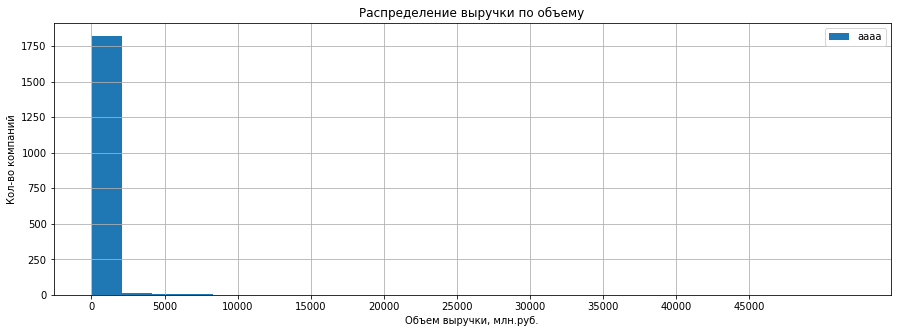

In [14]:
# распределение выручки компаний
sale_1 = data_1.SALE.hist(bins= 25, figsize=[15, 5]) # более 1750 компаний имеют выручку менее 5 000 млн.руб.

sale_1.set_title('Распределение выручки по объему')
sale_1.set_xlabel('Объем выручки, млн.руб.')
sale_1.set_ylabel('Кол-во компаний')
sale_1.set_xticks(range(0, 50000, 5000)) # разделение оси Х
sale_1.legend(['aaaa', 'bbbb'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



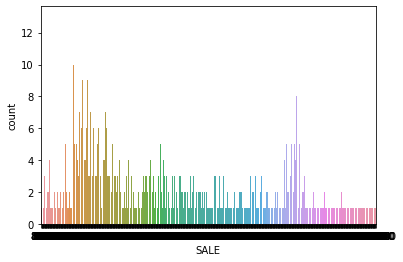

In [38]:
sns.countplot(data_1.SALE) # распределение выручки в этой группе 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


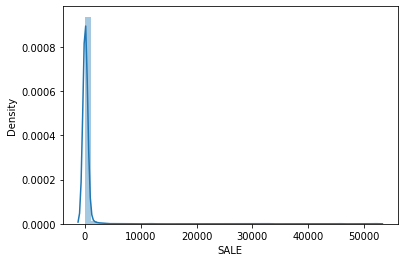

In [15]:
# гистограмма и график плотности распределения выручки компаний
sns.distplot(data_1['SALE'])

In [39]:
# графики в интерактивном режиме
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


In [17]:
# интерактивный график plotly - проверка кода
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_1.index, y= data_1.SALE, name='SALE'))
#fig.add_trace(go.Scatter(x=data_1.AKTIV, y= data_1.index,  name= 'AKTIV'))
fig.update_layout(title="Выручка",
                  xaxis_title="Выручка, млн.руб.",\
                  yaxis_title="№ компании",\
                  legend=dict(xanchor="center"))
fig.show(renderer="colab")

### AKTIV / рассмотрим активы компаний 

Text(0, 0.5, 'Кол-во компаний')

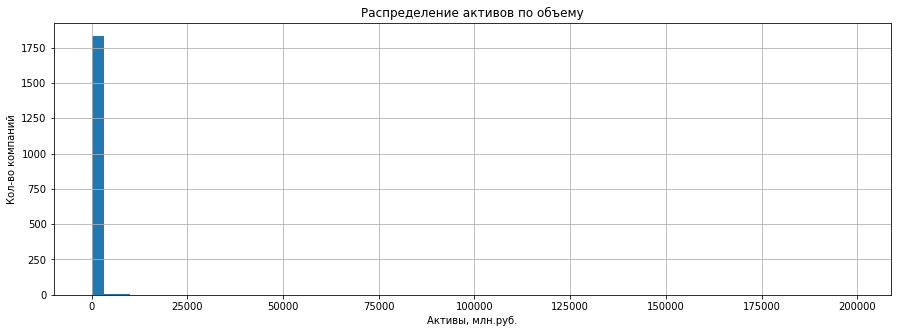

In [18]:
# распределение активов компаний
akt_1 = data_1.AKTIV.hist(bins= 60, figsize=[15, 5]) # более 1750 компаний имеют выручку менее 5 000 млн.руб.
#akt_1.set_xlim(0, 50000)
akt_1.set_title('Распределение активов по объему')
akt_1.set_xlabel('Активы, млн.руб.')
akt_1.set_ylabel('Кол-во компаний')

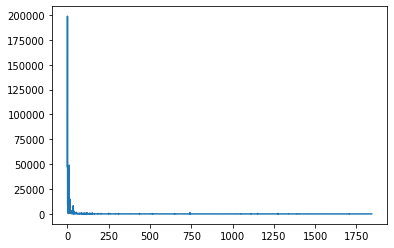

In [19]:
# график распределения активов компаний
data_1.AKTIV.plot()

In [44]:
data_1.head(3)

,name,inn,staff,income,expenses,nalog,AKTIV,SALE,groups
0,"""Сибирская Интернет Компания""",7708119944,0,0.0,0.0,0.0,47403.0,52074.0,>_10000
1,"""МЭЙЛ РУ""",7743001840,0,0.0,0.0,0.0,198742.0,45582.0,>_10000
2,"""Центр программ лояльности""",7702770003,166,33174.0,30617.0,1680.0,8723.0,32778.0,>_10000


In [21]:
# разобьем все компании на группы / до 1млн / от 1млн до 10млн / от 10млн до 100млн / от 100млн до 1000 / больше 1000
def grup(x):
    """ ф. для разделения значений по группам в зависимости от объема выручки, например до 1 млн.руб. 
        или от 1 до 100 млн.руб. и др.
    """
    if x < 1:
        return '<_1' # group E
    elif x >= 1 and x < 99:
        return '1_100' # group D
    elif x > 100 and x < 999:
        return '100_1000' # group C
    elif x >1000 and x < 9999:
        return '1000_10000' # group B
    else:
        return '>_10000' # group A

data_1['groups'] = data_1['SALE'].apply(grup)
data_1.head(3)

,name,inn,staff,income,expenses,nalog,AKTIV,SALE,groups
0,"""Сибирская Интернет Компания""",7708119944,0,0.0,0.0,0.0,47403.0,52074.0,>_10000
1,"""МЭЙЛ РУ""",7743001840,0,0.0,0.0,0.0,198742.0,45582.0,>_10000
2,"""Центр программ лояльности""",7702770003,166,33174.0,30617.0,1680.0,8723.0,32778.0,>_10000


In [45]:
# кол-во компаний в каждой группе
data_2 = data_1.groupby('groups', as_index=False).agg({'SALE':'count'}).rename(columns={'groups':'группа','SALE':'компаний в группе'})
data_2

,группа,компаний в группе
0,1000_10000,42
1,100_1000,305
2,1_100,1490
3,>_10000,6


Text(0, 0.5, 'Кол-во компаний в группе')

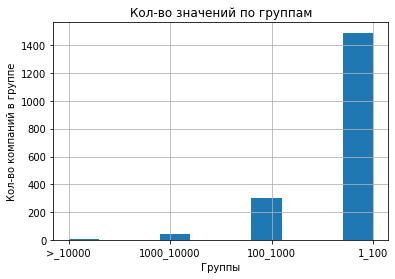

In [47]:
groups1 = data_1.groups.hist() # кол-во значений по группам
groups1.set_title('Кол-во значений по группам')
groups1.set_xlabel('Группы')
groups1.set_ylabel('Кол-во компаний в группе')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/di

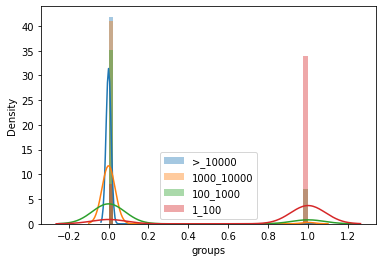

In [50]:
# 
for i in data_1['groups'].unique():
    sns.distplot(data_1['groups'] == i, label= i) # распределение уникальных значений по группам 
plt.legend()

In [104]:
data_1.groupby('groups', as_index=False)\
      .agg({'AKTIV':'count', 'SALE':'mean'})\
      .rename(columns={'groups':'группа','AKTIV':'кол-во компаний', 'SALE':'Среднее по выручке, млн.руб.'})\
      .value_counts(['Среднее по выручке, млн.руб.', 'группа', 'кол-во компаний'])
# это среднее по выручке среди групп

Среднее по выручке, млн.руб.  группа      кол-во компаний
23787.650000                  >_10000     6                  1
2622.238095                   1000_10000  42                 1
273.118033                    100_1000    305                1
32.099443                     1_100       1490               1
dtype: int64

## Анализ по группам

### - группа компаний с выручкой более 10000 млн.

In [25]:
data_groups_1 = data_1.query("groups == '>_10000'")
print('Количество компаний с выручкой более 10 000 млн.руб. - ', data_groups_1.shape[0])

Количество компаний с выручкой более 10 000 млн.руб. -  6


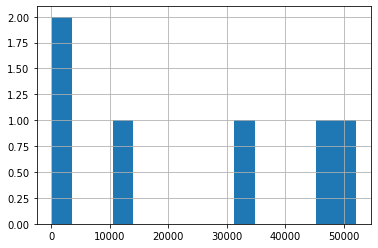

In [26]:
# 
data_groups_1.SALE.hist(bins= 15) # распределение компаний в группе с выручкой более 10000 млн.руб.

In [51]:
# среднее, минимальное и максимальное значеие в группе
data_groups_1.describe()

,inn,staff,income,expenses,nalog,AKTIV,SALE
count,6.000000e+00,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,7.718017e+09,393.333333,7585.833333,7100.600000,595.005000,43845.100000,23787.650000
std,1.641772e+07,855.525492,13435.748768,12446.629243,916.010379,77912.538356,22869.036529
min,7.701987e+09,0.000000,0.000000,0.000000,0.000000,46.600000,99.000000
25%,7.704107e+09,4.000000,25.000000,16.900000,1.132500,2097.000000,3098.175000
50%,7.716324e+09,29.500000,101.500000,83.800000,10.015000,8381.500000,22435.500000
75%,7.726904e+09,135.250000,9129.250000,8889.250000,1263.875000,37733.000000,42381.000000
max,7.743002e+09,2135.000000,33174.000000,30617.000000,1870.000000,198742.000000,52074.000000


### - группа компаний с выручкой от 1000 до  10000 млн.

In [28]:
data_groups_2 = data_1.query("groups == '1000_10000'")
# кол-во компаний 
print('Количество компаний с выручкой от 1 000 до  10 000 млн.руб. - ', data_groups_2.shape[0])

Количество компаний с выручкой от 1 000 до  10 000 млн.руб. -  42


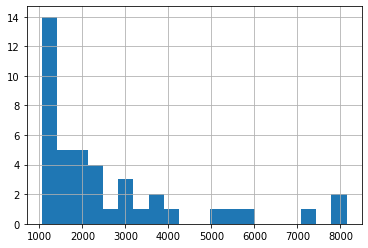

In [106]:
# распределений выручки у этой группы компаний
data_groups_2.SALE.hist(bins=20)

Text(-5000, 36, 'Распределение значений выручки и персонала в этой группе')

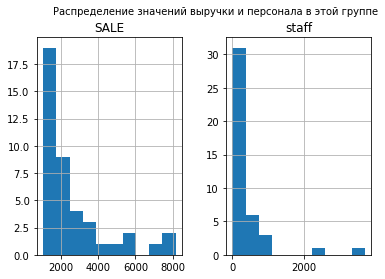

In [110]:
data_groups_2.loc[:,['SALE', 'staff']].hist()
plt.text(-5000, 36, 'Распределение значений выручки и персонала в этой группе')

In [72]:
fig = go.Figure() # создадим интерактивный график

fig.add_trace(go.Scatter(x=data_groups_2.SALE, y= data_groups_2.index, name = 'SALE'))
fig.add_trace(go.Scatter(x=data_groups_2.staff, y= data_groups_2.index, name= 'staff'))
fig.update_layout(title="Выручка и количество персонала компании",\
                  xaxis_title="Выручка, млн.руб. / Персонал, чел.",\
                  yaxis_title="№ компании")
fig.show(renderer="colab")

In [52]:
# среднее, минимальное и максимальное значение в группе
data_groups_2.describe()

,inn,staff,income,expenses,nalog,AKTIV,SALE
count,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,7.621730e+09,370.023810,2171.619048,2132.095238,239.187619,3440.714286,2622.238095
std,1.094515e+09,668.137071,1990.918037,2207.196454,278.839199,7814.149874,1925.097195
min,3.123305e+09,0.000000,0.000000,0.000000,0.000000,105.000000,1063.000000
25%,7.706636e+09,19.750000,1128.750000,1081.750000,71.050000,480.000000,1206.250000
50%,7.723570e+09,174.500000,1688.000000,1496.000000,166.500000,1408.000000,1981.500000
75%,7.735578e+09,390.250000,2664.000000,2528.000000,314.750000,2758.000000,3133.750000
max,9.710053e+09,3689.000000,8296.000000,10351.000000,1407.000000,48950.000000,8141.000000


### - группа компаний с выручкой от 100 до  1000 млн.

In [32]:
data_groups_3 = data_1.query("groups == '100_1000'")
print('Количество компаний с выручкой от 100 до  1 000 млн.руб. - ', data_groups_3.shape[0], '\n\n')

Количество компаний с выручкой от 100 до  1 000 млн.руб. -  305 




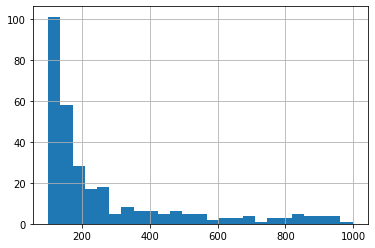

In [80]:
# распределение значений выручки у компаний этой группы
data_groups_3.SALE.hist(bins= 25)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



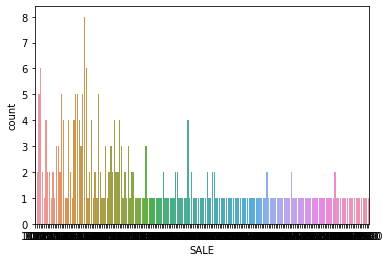

In [74]:
# то же самое в seaborn
sns.countplot(data_groups_3.SALE)

In [81]:
# среднее, минимальное и максимальное значение в группе
data_groups_3.describe()

,inn,staff,income,expenses,nalog,AKTIV,SALE
count,3.050000e+02,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,6.877253e+09,59.701639,290.770492,265.888721,40.369180,150.471207,273.118033
std,1.854065e+09,81.680375,249.579725,265.750616,64.077362,207.536630,224.329599
min,8.160287e+08,0.000000,0.000000,0.000000,0.000000,0.458000,101.000000
25%,6.670021e+09,14.000000,133.000000,114.000000,8.760000,37.600000,131.000000
50%,7.710606e+09,34.000000,182.000000,160.000000,21.200000,73.500000,167.000000
75%,7.729679e+09,71.000000,352.000000,330.000000,46.500000,170.000000,322.000000
max,9.731001e+09,793.000000,1393.000000,2267.000000,787.000000,1606.000000,998.000000


In [111]:
fig = go.Figure() # создадим интерактивный график

fig.add_trace(go.Scatter(x=data_groups_3.SALE, y= data_groups_3.index, name = 'SALE'))
fig.add_trace(go.Scatter(x=data_groups_3.staff, y= data_groups_3.index, name= 'staff'))
fig.update_layout(title="Выручка и количество персонала компании",\
                  xaxis_title="Выручка, млн.руб. / Персонал, чел.",\
                  yaxis_title="№ компании")
fig.show(renderer="colab")

### - группа компаний с выручкой от 1 до  100 млн.

In [34]:
data_groups_4 = data_1.query("groups == '1_100'")
print('Количество компаний с выручкой от 1 до  100 млн.руб. - ', data_groups_4.shape[0])

Количество компаний с выручкой от 1 до  100 млн.руб. -  1490


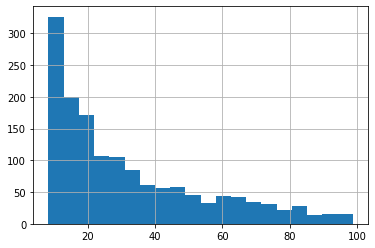

In [82]:
data_groups_4.SALE.hist(bins=20) # распределение выручки в этой группе

In [83]:
# среднее, минимальное и максимальное значение в группе
data_groups_4.describe()

,inn,staff,income,expenses,nalog,AKTIV,SALE
count,1.490000e+03,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000,1490.000000
mean,6.155837e+09,14.780537,33.075819,30.481020,172.673248,21.079799,32.099443
std,2.200691e+09,16.242480,25.597765,30.603334,289.631134,49.418822,22.649462
min,2.450215e+08,0.000000,0.000000,0.000000,0.000000,0.000000,8.340000
25%,5.018148e+09,4.000000,13.625000,12.000000,2.100000,4.230000,13.825000
50%,7.325072e+09,9.000000,24.000000,21.450000,4.870000,9.700000,23.650000
75%,7.725553e+09,19.750000,46.650000,41.675000,276.000000,21.950000,45.425000
max,9.731028e+09,103.000000,281.000000,572.000000,998.000000,1273.000000,98.800000


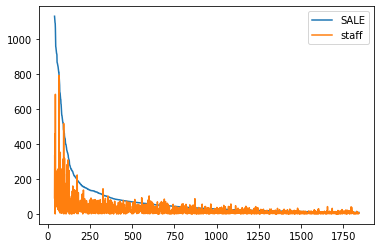

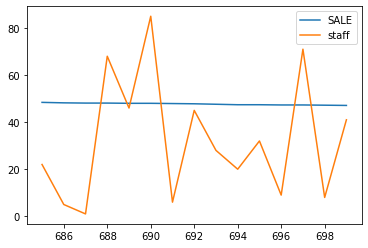

In [36]:
# выручка и персонал
data_pers = data_1.loc[:,['SALE', 'staff']]
data_pers[40:].plot() # интересно почему кол-во человек нигде почти не превышает линию обьема выручки / 
data_pers[685:700].plot() # на отрезке - значения выручки и кол-ва персонала

In [37]:
# анализ продолжится дальше